In [1]:
from pathlib import Path
from pyhdf.SD import SD, SDC
import pprint
import numpy as np
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
from mpl_toolkits.basemap import Basemap, cm


0 Longitude
1 Latitude
2 Scan_Start_Time
3 Solar_Zenith
4 Solar_Azimuth
5 Sensor_Zenith
6 Sensor_Azimuth
7 Scattering_Angle
8 Land_sea_Flag
9 Aerosol_Cldmask_Land_Ocean
10 Cloud_Pixel_Distance_Land_Ocean
11 Land_Ocean_Quality_Flag
12 Optical_Depth_Land_And_Ocean
13 Image_Optical_Depth_Land_And_Ocean
14 Average_Cloud_Pixel_Distance_Land_Ocean
15 Aerosol_Type_Land
16 Fitting_Error_Land
17 Surface_Reflectance_Land
18 Corrected_Optical_Depth_Land
19 Corrected_Optical_Depth_Land_wav2p1
20 Optical_Depth_Ratio_Small_Land
21 Number_Pixels_Used_Land
22 Mean_Reflectance_Land
23 STD_Reflectance_Land
24 Mass_Concentration_Land
25 Aerosol_Cloud_Fraction_Land
26 Quality_Assurance_Land
27 Solution_Index_Ocean_Small
28 Solution_Index_Ocean_Large
29 Effective_Optical_Depth_Best_Ocean
30 Effective_Optical_Depth_Average_Ocean
31 Optical_Depth_Small_Best_Ocean
32 Optical_Depth_Small_Average_Ocean
33 Optical_Depth_Large_Best_Ocean
34 Optical_Depth_Large_Average_Ocean
35 Mass_Concentration_Ocean
36 Aerosol_

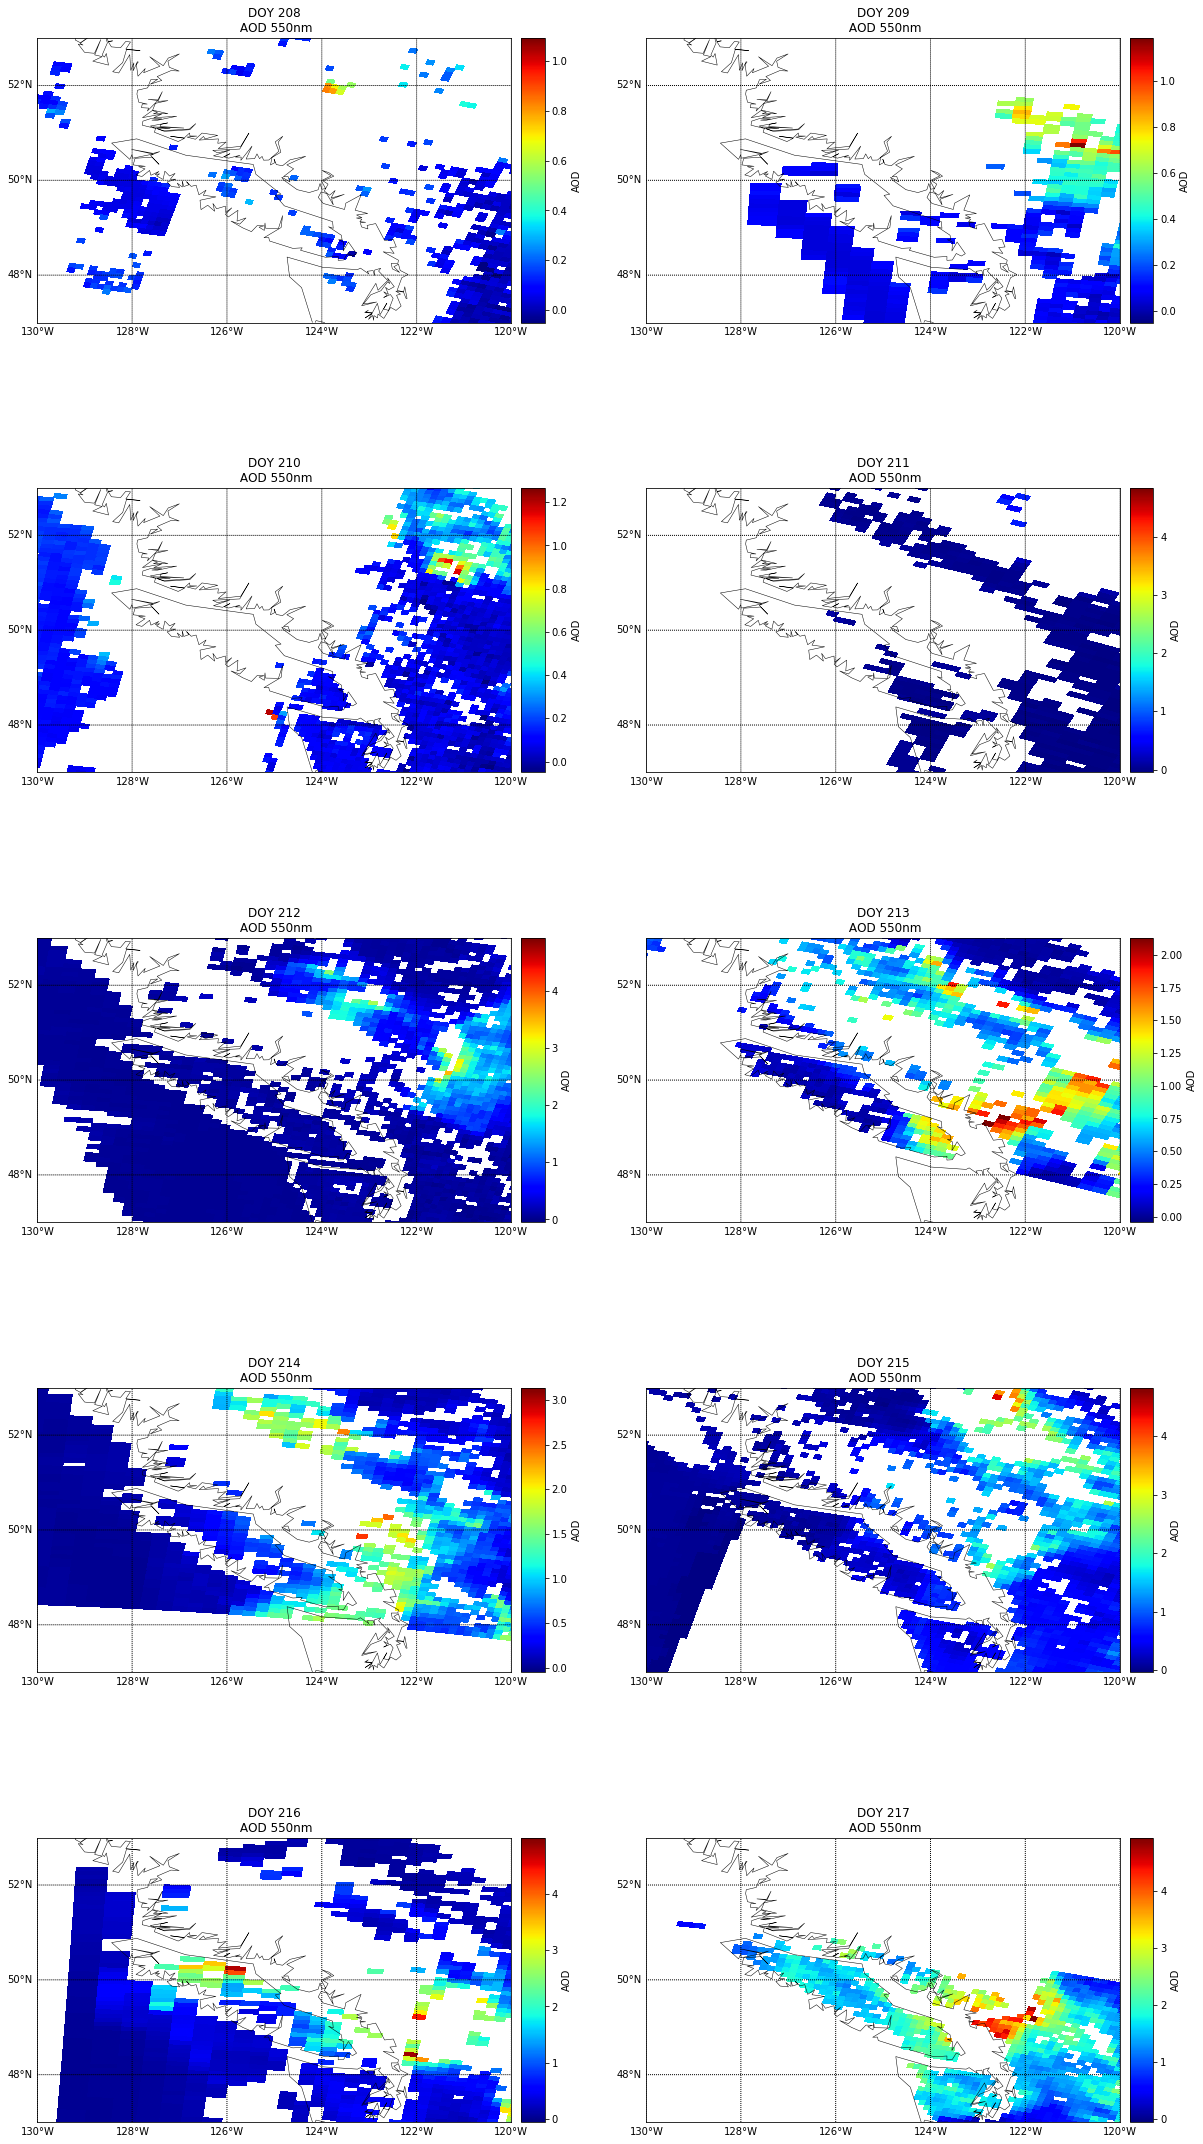


All valid files have been processed.


274320

In [38]:
home = Path.home()
data_dir = home / Path("Desktop\Edumacation\GEOB 402\FINAL PROJECT\AOD Data\MODIS files")
hdf_files=list(data_dir.glob("MOD04_L2*.hdf"))
#file_name = str(data_dir / Path(hdf_files[0]))
# print(f'reading {file_name}')
#the_file = SD(file_name, SDC.READ)

datasets_dict = the_file.datasets()
for idx,sds in enumerate(datasets_dict.keys()):
    print(idx,sds)


i = 1
lenofall = 0
fig = plt.figure(figsize=(20,40))
for FILE_NAME in hdf_files:
    FILE_NAME = str(data_dir / Path(FILE_NAME))
    if '3K' in FILE_NAME:#then this is a 3km MODIS file
        print('This is a 3km MODIS file. Here is some information: ')
        SDS_NAME='Optical_Depth_Land_And_Ocean' # The name of the sds to read
    elif 'L2' in FILE_NAME: #Same as above but for 10km MODIS file
        print('This is a 10km MODIS file. Here is some information: ')
        SDS_NAME='AOD_550_Dark_Target_Deep_Blue_Combined'
    else:#if it is neither 3km nor 10km, then this will skip the rest of this loop iteration
        print('The file :',FILE_NAME, ' is not a valid MODIS file (Or is named incorrectly). \n')
        continue
    try:
        # open the hdf file for reading
        the_file=SD(FILE_NAME, SDC.READ)
    except:
        print('Unable to open file: \n' + FILE_NAME + '\n Skipping...')
        continue
        
    # Get lat and lon info
    lat = the_file.select('Latitude')
    latitude = lat[:]
    # min_lat=latitude.min()
    # max_lat=latitude.max()
    lon = the_file.select('Longitude')
    longitude = lon[:]
    # min_lon=longitude.min()
    # max_lon=longitude.max()

    min_lat=47
    max_lat=53
    min_lon=-130
    max_lon=-120

    bb_lat=49.5238
    bb_lon=124.8500
    
    try:
        sds=the_file.select(SDS_NAME)
    except:
        print('Ya goof, your MODIS hdf file does not contain the SDS:',SDS_NAME,'. Fix this.')
        sys.exit()
      
    #get scale factor for AOD SDS
    attributes=sds.attributes()
    scale_factor=attributes['scale_factor']

    #get valid range for AOD SDS
    range=sds.getrange()
    min_range=min(range)
    max_range=max(range)

    #get SDS data
    data=sds.get()

    #get data within valid range
    valid_data=data.ravel()
    valid_data=[x for x in valid_data if x>=min_range]
    valid_data=[x for x in valid_data if x<=max_range]
    valid_data=np.asarray(valid_data)

    #scale the valid data
    valid_data=valid_data*scale_factor

    #find the average
    average=sum(valid_data)/len(valid_data)

    #find the standard deviation
    stdev=np.std(valid_data)

    #print information
    print('\nThe valid range of values is: ',round(min_range*scale_factor,3), ' to ',round(max_range*scale_factor,3),'\nThe average is: ',round(average,3),'\nThe standard deviation is: ',round(stdev,3))
    print('The range of latitude in this file is: ',min_lat,' to ',max_lat, 'degrees \nThe range of longitude in this file is: ',min_lon, ' to ',max_lon,' degrees')

    attrs = sds.attributes(full=1)
    fillvalue=attrs['_FillValue']

    # # fillvalue[0] is the attribute value (-9999)
    fv = fillvalue[0]

    # #turn fillvalues to NaN
    data=data.astype(float)
    data[data == fv] = np.nan
    data = np.ma.masked_array(data, np.isnan(data))
    
    
    axes = plt.subplot(5,2,i)
    m = Basemap(projection='cyl', resolution='l', llcrnrlat=min_lat, urcrnrlat = max_lat, llcrnrlon=min_lon, urcrnrlon = max_lon)
    m.drawcoastlines(linewidth=0.5)
    m.drawparallels(np.arange(-90., 120., 2.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180., 181.,2.), labels=[0, 0, 0, 1])
    x, y = m(longitude, latitude)
    m.pcolormesh(x, y, data*scale_factor, cmap=plt.cm.jet)
    cb = m.colorbar()
    cb.set_label('AOD')
    
    # #title the plot
    plotTitle=FILE_NAME[-30:-27]
    plt.title('{0}{1}\n {2}'.format("DOY ", plotTitle, "AOD 550nm"))
    fig = plt.gcf()
    i+=1
    
    scan_time=the_file.select('Scan_Start_Time')
    scan_time=(scan_time.get()).ravel()
    scan_time=scan_time[:]
    #get the date info from scan_time
    year=np.zeros(scan_time.shape[0])
    
    lenofall += len(year)
plt.show()
    
    
pngfile = '{0}.png'.format(plotTitle)
fig.savefig(pngfile)
print('\nAll valid files have been processed.')       
lenofall
        
# stars='*'*50
# print((f'\n{stars}\nnumber of datasets, number of attributes'
#        f'={the_file.info()}\n{stars}\n'
#        f'\nHere is the help file for the info funtion:\n'))
# help(SD.info)